In [1]:
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')

from utils import utils, model_fetch

metrics_dict = {}


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
# Which model to evaluate


####### Change This #######
model_of_interest = "cutout"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "baseline_teacher": base_path + 'resnet18_baseline_retrained_1586751743/model_best.pth.tar',
    "mixup_teacher": base_path + 'resnet18_mixup_retrained_1586457991/checkpoint.pth.tar',
    "cutout_teacher": base_path + 'resnet18-cutout-restart-again_1586956477/model_best.pth.tar',
    "cutmix_teacher": base_path + 'resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar',
    "augmented_teacher": base_path + 'resnet18_augmented_retrained_1586751381/checkpoint.pth.tar',
    
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
    "augmented": base_path + ''
}
if 'teacher' in model_of_interest:
    model = model_fetch.fetch_student('resnet18')
else:
    model = model_fetch.fetch_student('lenet')

_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/lenet-student-cutout_1587345858/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/lenet-student-cutout_1587345858/model_best.pth.tar' (epoch 60)
Current Loss :  1.0629366817353647


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (linear): Identity()
)

In [28]:
# Load data as torch tensor and labels as numpy array

data = np.load('../data/cifar-10.1/cifar10.1_v6_data.npy')
data = np.transpose(data, (0,3,1,2))
data = torch.Tensor(data)

labels = np.load('../data/cifar-10.1/cifar10.1_v6_labels.npy')

In [29]:
# Create softmax preds from model using above dataset
if True:
    preds = []
    for i in tqdm(range(len(data))):
        img = data[i]
        img = img.unsqueeze(0)
        softmax = torch.nn.Softmax(dim=1)
        pred = softmax(model(img))
        preds.append(pred.detach().numpy())

    preds = np.array(preds).squeeze(axis=1)
    preds.shape

100%|██████████| 2000/2000 [00:00<00:00, 2515.94it/s]


In [30]:
# Create Embedding generating Model
if True:
    embed_model = model
    class Identity(torch.nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, x):
            return x
    embed_model.linear = Identity()
    
if True:
    embeds = []

    for i in tqdm(range(len(data))):
        img = data[i]
        img = img.unsqueeze(0)
        embedding = embed_model(img).detach().numpy().squeeze(0)
        embeds.append(embedding)
    embeds = np.array(embeds)
    embeds.shape
    
if True:
    save_path_embeds = '../../results/embeddings_cifar10-1/' + model_of_interest+ '.npy'
    np.save(save_path_embeds, embeds)

100%|██████████| 2000/2000 [00:00<00:00, 2869.76it/s]


In [31]:
# Update existing Metrics Dictionary

metrics = utils.find_metrics(preds, labels, False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,cutmix,baseline,mixup,cutout
accuracy,0.294000,0.304500,0.314000,0.308500
precision,0.418800,0.418593,0.347085,0.436655
recall,0.294000,0.304500,0.314000,0.308500
f1-score,0.247246,0.274940,0.267271,0.278138


In [32]:
# Plot Confusion Matrix

y_pred = np.argmax(preds, axis=1)
y_true = labels
conf_mat = cm(y_true, y_pred, normalize='true')

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

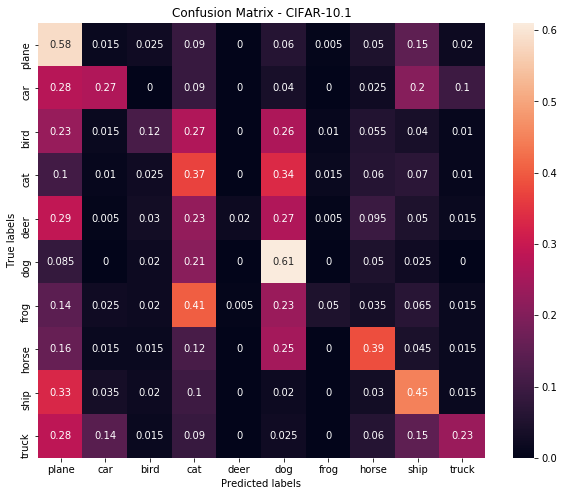

In [33]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CIFAR-10.1')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

In [34]:
pd.DataFrame(metrics_dict)

,cutmix,baseline,mixup,cutout
accuracy,0.294000,0.304500,0.314000,0.308500
precision,0.418800,0.418593,0.347085,0.436655
recall,0.294000,0.304500,0.314000,0.308500
f1-score,0.247246,0.274940,0.267271,0.278138


In [10]:
METRICS_STUDENT_DICT = {
    "cutout":{
        "accuracy": 0.644200,
        "precision": 0.643208,
        "recall": 0.644200,
        "f1-score": 0.643570,
        "kl-divergence":0,
    },
    "baseline": {
        "accuracy": 0.304500,
        "precision": 0.418593,
        "recall": 0.304500,
        "f1-score": 0.274940,
    },
     "mixup": {
        "accuracy": 0.314000,
        "precision": 0.347085,
        "recall": 0.314000,
        "f1-score": 0.267271,
     },
     "cutmix": {
        "accuracy": 0.294000,
        "precision": 0.418800,
        "recall": 0.294000,
        "f1-score": 0.247246,
     },
     "cutout": {
        "accuracy": 0.308500,
        "precision": 0.436655,
        "recall": 0.308500,
        "f1-score": 0.278138,
     },
     "augmented": {}
}
